In [1]:
import pandas as pd
import requests
import json
import datetime
from statsmodels.tsa.stattools import coint
import numpy as np
from bs4 import BeautifulSoup
import requests
import numpy as np
from scipy import stats
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import copulae

## Back-Testing System

Here, we will build a backtesting system for pair trading strategies. First, we will define necessary functions to fetch the historical price from Binance.


## Data Feeding 

In [2]:
#fetch Candlesticks

def getcandle(ticker,interval,startTime,endTime):
    parameters = {'symbol': str(ticker),'interval': str(interval),'startTime': int(startTime),'endTime': int(endTime)}
    res = json.loads(requests.get("https://api.binance.com/api/v3/klines", params=parameters).text)
    GetPrice = pd.DataFrame(res)
    GetPrice.columns = ['Open time', 'Open', 'High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore']
    GetPrice['Open time'] = GetPrice['Open time'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    GetPrice['Close time'] = GetPrice['Close time'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    GetPrice["Open time"] = pd.to_datetime(GetPrice["Open time"])
    GetPrice["Close time"] = pd.to_datetime(GetPrice["Open time"])
    GetPrice["Open"] = GetPrice["Open"] .astype('float')
    GetPrice["High"] = GetPrice["High"] .astype('float')
    GetPrice["Low"] = GetPrice["Low"] .astype('float')
    GetPrice["Close"] = GetPrice["Close"] .astype('float')
    GetPrice["Volume"] = GetPrice["Volume"] .astype('float')
    return(GetPrice)

#Generate DataFrame
def priceFrame(ticker,interval,startTime,endTime):
    Frame = pd.DataFrame()
    for i in ticker:
        close = (getcandle(i,interval,startTime,endTime).set_index('Open time')['Close']).astype(float)
        Frame = pd.concat([Frame,close],axis=1)
    Frame.columns = ticker
    Frame.index = pd.DatetimeIndex(Frame.index)
    return(Frame)

#Ciontegation Check


## Pair Selection




In [3]:
#Min-Max Normalize
def MinMax_Normalize(df):
    return((df - df.min())/(df.max() - df.min()))

#Standardize
def Standard_Normalize(df):
    return((df - df.mean())/df.std())

def Relative_Return(df):
    return(((df - df.shift())/df.shift()).dropna())

#Ciontegation Check
def cointplot(Combine):
    ncol = len(Combine.columns)
    cointMat = np.zeros((ncol, ncol))
    for i in range(len(Combine.columns)):
        for j in range(len(Combine.columns)):
            st, pvalue, crit = coint(Combine[Combine.columns[i]],Combine[Combine.columns[j]])
            cointMat[i,j] = pvalue
    cointTab = pd.DataFrame(cointMat)
    cointTab.columns = Combine.columns
    cointTab.index = Combine.columns
    return(cointTab)

#Get Top Marekt Cap Coin from https://www.coingecko.com/en
def GetTopCoin(Num):
    URL = requests.get('https://www.coingecko.com/en')
    soup = BeautifulSoup(URL.text, 'html.parser')
    TickerList = soup.find_all("span", {"class": "tw-hidden d-lg-inline font-normal text-3xs ml-2"})
    TickerRank = [i.text.replace("\n", "") for i in TickerList]
    return(TickerRank[0:(int(Num)-1)])


def Pair_Selection_Smallest_Distance(df):
    row, col = df.shape
    df = MinMax_Normalize(df)
    DistMat = np.zeros((col,col))
    for i in range(col):
        for j in range(col):
            DistMat[i][j] = sum((df.iloc[:,i]-df.iloc[:,j])**2)
    DistMat = pd.DataFrame(DistMat)
    DistMat.columns = df.columns
    DistMat.index = df.columns
    return(DistMat)

def cointplot(Combine):
    #Engle-Granger test
    ncol = len(Combine.columns)
    cointMat = np.zeros((ncol, ncol))
    for i in range(len(Combine.columns)):
        for j in range(len(Combine.columns)):
            st, pvalue, crit = coint(Combine[Combine.columns[i]],Combine[Combine.columns[j]])
            cointMat[i,j] = pvalue
    cointTab = pd.DataFrame(cointMat)
    cointTab.columns = Combine.columns
    cointTab.index = Combine.columns
    return(cointTab)


def hurst(ts):
    #H < 0.5 - Mean Reverting, H = 0.5 - GBM, H > 0.5 Trending
    lags = range(2, 100)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = polyfit(log(lags), log(tau), 1)
    return poly[0]*2.0

def hurstplot(Combine):
    ncol = len(Combine.columns)
    hurstMat = np.zeros((ncol, ncol))
    for i in range(len(Combine.columns)):
        for j in range(len(Combine.columns)):
            pvalue= hurst(np.array(Combine[Combine.columns[i]] - Combine[Combine.columns[j]]))
            hurstMat[i,j] = pvalue
    hurstTab = pd.DataFrame(hurstMat)
    hurstTab.columns = Combine.columns
    hurstTab.index = Combine.columns
    return(hurstTab)

def ADF(df):
    # p > 0.05 the data has a unit root, p < 0.05  stationary 
    ncol = len(Combine.columns)
    ADFMat = np.zeros((ncol, ncol))
    for i in range(len(Combine.columns)):
        for j in range(len(Combine.columns)):
            pvalue= adfuller(Combine[Combine.columns[i]] - Combine[Combine.columns[j]])[1]
            ADFMat[i,j] = pvalue
    ADFTab = pd.DataFrame(ADFMat)
    ADFTab.columns = Combine.columns
    ADFTab.index = Combine.columns
    return(ADFTab)


## Generating Trading Signal

### Example

Retrieving the candlesticks data from Binance of BTC/USDT and creating the data frame of the closing price.

In [4]:
interval = '1d'
startTime =  datetime.datetime(2021, 4, 1, 0, 0).timestamp()*1000
endTime = datetime.datetime(2021, 4, 30, 0, 0).timestamp()*1000
getcandle('BTCUSDT',interval,startTime,endTime)

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2021-04-01,58739.46,59490.00,57935.45,58720.44,47415.617220,2021-04-01,2789238879.94337348,1594431,22966.25673600,1351151697.89222195,0
1,2021-04-02,58720.45,60200.00,58428.57,58950.01,47382.418781,2021-04-02,2811159761.26846735,1666356,23695.69515400,1406393729.83076923,0
2,2021-04-03,58950.01,59791.72,56880.00,57051.94,47409.852113,2021-04-03,2783151686.16453709,1606805,23057.96701700,1353960264.62196262,0
3,2021-04-04,57051.95,58492.85,56388.00,58202.01,41314.081973,2021-04-04,2380139010.73023250,1499113,20609.13416100,1187123542.57988340,0
4,2021-04-05,58202.01,59272.00,56777.77,59129.99,54258.015790,2021-04-05,3155214764.16448552,2035877,27269.49269000,1586344787.55416885,0
5,2021-04-06,59129.99,59495.24,57413.02,57991.15,54201.000727,2021-04-06,3166911557.14815778,1960513,26699.19787200,1560539125.77805926,0
6,2021-04-07,57990.03,58655.00,55473.00,55953.45,71228.405659,2021-04-07,4053294016.48451469,2206433,34737.58215500,1977438033.92862991,0
7,2021-04-08,55953.44,58153.31,55700.00,58077.52,44283.147019,2021-04-08,2531779682.55242696,1661080,22161.69051000,1267126859.44389048,0
8,2021-04-09,58077.52,58894.90,57654.00,58142.54,40831.884911,2021-04-09,2378340697.28958427,1615962,20354.23445600,1185679367.91003643,0
9,2021-04-10,58142.55,61500.00,57900.01,59769.13,69906.424117,2021-04-10,4197138552.46903365,2470398,36018.63756600,2162858397.75343994,0


In [5]:
interval = '1d'
startTime =  datetime.datetime(2019, 1, 1, 0, 0).timestamp()*1000
endTime = datetime.datetime(2020, 1, 1, 0, 0).timestamp()*1000
ticker = ['BTCUSDT','LTCUSDT','ETHUSDT','BNBUSDT','XRPUSDT','ADAUSDT']
Combine = priceFrame(ticker,interval,startTime,endTime)
Combine

,BTCUSDT,LTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT
2019-01-01,3797.14,31.48,139.10,5.9910,0.36080,0.04198
2019-01-02,3858.56,32.67,152.01,6.0510,0.36882,0.04433
2019-01-03,3766.78,31.39,146.30,5.7979,0.35240,0.04205
2019-01-04,3792.01,31.76,151.97,5.9692,0.35308,0.04301
2019-01-05,3770.96,34.33,152.83,5.9625,0.34851,0.04403
...,...,...,...,...,...,...
2019-12-28,7316.14,42.83,128.11,13.6779,0.19320,0.03365
2019-12-29,7388.24,43.08,134.36,14.1040,0.19653,0.03412
2019-12-30,7246.00,42.38,131.59,13.8597,0.19326,0.03344
2019-12-31,7195.23,41.30,129.16,13.7161,0.19295,0.03285


Ckeck Correlation, Cointegation and Minimum Distance Matrix

In [6]:
hurstplot(Combine)

<ipython-input-3-aab59d3e9f01>:64: RuntimeWarning: divide by zero encountered in log
  poly = polyfit(log(lags), log(tau), 1)


,BTCUSDT,LTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT
BTCUSDT,NaN,0.546117,0.547684,0.546975,0.547485,0.547483
LTCUSDT,0.546117,NaN,0.395612,0.533535,0.600868,0.600672
ETHUSDT,0.547684,0.395612,NaN,0.497762,0.526908,0.526844
BNBUSDT,0.546975,0.533535,0.497762,NaN,0.633320,0.632655
XRPUSDT,0.547485,0.600868,0.526908,0.633320,NaN,0.398661
ADAUSDT,0.547483,0.600672,0.526844,0.632655,0.398661,NaN


In [7]:
Combine.corr()

,BTCUSDT,LTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT
BTCUSDT,1.000000,0.606846,0.756928,0.768993,0.061400,0.194554
LTCUSDT,0.606846,1.000000,0.919818,0.934528,0.704549,0.855299
ETHUSDT,0.756928,0.919818,1.000000,0.913481,0.655957,0.707115
BNBUSDT,0.768993,0.934528,0.913481,1.000000,0.511983,0.706199
XRPUSDT,0.061400,0.704549,0.655957,0.511983,1.000000,0.823541
ADAUSDT,0.194554,0.855299,0.707115,0.706199,0.823541,1.000000


In [8]:
Combine.corr().to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &   BTCUSDT &   LTCUSDT &   ETHUSDT &   BNBUSDT &   XRPUSDT &   ADAUSDT \\\\\n\\midrule\nBTCUSDT &  1.000000 &  0.606846 &  0.756928 &  0.768993 &  0.061400 &  0.194554 \\\\\nLTCUSDT &  0.606846 &  1.000000 &  0.919818 &  0.934528 &  0.704549 &  0.855299 \\\\\nETHUSDT &  0.756928 &  0.919818 &  1.000000 &  0.913481 &  0.655957 &  0.707115 \\\\\nBNBUSDT &  0.768993 &  0.934528 &  0.913481 &  1.000000 &  0.511983 &  0.706199 \\\\\nXRPUSDT &  0.061400 &  0.704549 &  0.655957 &  0.511983 &  1.000000 &  0.823541 \\\\\nADAUSDT &  0.194554 &  0.855299 &  0.707115 &  0.706199 &  0.823541 &  1.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [9]:
hurstplot(Combine).to_latex()

<ipython-input-3-aab59d3e9f01>:64: RuntimeWarning: divide by zero encountered in log
  poly = polyfit(log(lags), log(tau), 1)


'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &   BTCUSDT &   LTCUSDT &   ETHUSDT &   BNBUSDT &   XRPUSDT &   ADAUSDT \\\\\n\\midrule\nBTCUSDT &       NaN &  0.546117 &  0.547684 &  0.546975 &  0.547485 &  0.547483 \\\\\nLTCUSDT &  0.546117 &       NaN &  0.395612 &  0.533535 &  0.600868 &  0.600672 \\\\\nETHUSDT &  0.547684 &  0.395612 &       NaN &  0.497762 &  0.526908 &  0.526844 \\\\\nBNBUSDT &  0.546975 &  0.533535 &  0.497762 &       NaN &  0.633320 &  0.632655 \\\\\nXRPUSDT &  0.547485 &  0.600868 &  0.526908 &  0.633320 &       NaN &  0.398661 \\\\\nADAUSDT &  0.547483 &  0.600672 &  0.526844 &  0.632655 &  0.398661 &       NaN \\\\\n\\bottomrule\n\\end{tabular}\n'

In [10]:
cointplot(Combine)

C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable i

,BTCUSDT,LTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT
BTCUSDT,0.000000,0.887417,0.797157,0.853051,0.746412,0.802405
LTCUSDT,0.834128,0.000000,0.194773,0.176816,0.187184,0.535935
ETHUSDT,0.845012,0.165401,0.000000,0.047824,0.697233,0.788753
BNBUSDT,0.769530,0.119777,0.045219,0.000000,0.345030,0.550232
XRPUSDT,0.700132,0.391597,0.828498,0.572436,0.000000,0.341553
ADAUSDT,0.741408,0.535732,0.596504,0.523491,0.323058,0.000000


In [11]:
cointplot(Combine).to_latex()

C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\OPOR\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable i

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &   BTCUSDT &   LTCUSDT &   ETHUSDT &   BNBUSDT &   XRPUSDT &   ADAUSDT \\\\\n\\midrule\nBTCUSDT &  0.000000 &  0.887417 &  0.797157 &  0.853051 &  0.746412 &  0.802405 \\\\\nLTCUSDT &  0.834128 &  0.000000 &  0.194773 &  0.176816 &  0.187184 &  0.535935 \\\\\nETHUSDT &  0.845012 &  0.165401 &  0.000000 &  0.047824 &  0.697233 &  0.788753 \\\\\nBNBUSDT &  0.769530 &  0.119777 &  0.045219 &  0.000000 &  0.345030 &  0.550232 \\\\\nXRPUSDT &  0.700132 &  0.391597 &  0.828498 &  0.572436 &  0.000000 &  0.341553 \\\\\nADAUSDT &  0.741408 &  0.535732 &  0.596504 &  0.523491 &  0.323058 &  0.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [12]:
Pair_Selection_Smallest_Distance(Combine)

,BTCUSDT,LTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT
BTCUSDT,0.000000,20.621483,14.205670,11.999814,40.035272,45.637961
LTCUSDT,20.621483,0.000000,3.684099,5.611776,13.327786,7.578820
ETHUSDT,14.205670,3.684099,0.000000,8.521427,14.769379,14.514520
BNBUSDT,11.999814,5.611776,8.521427,0.000000,19.129902,17.770544
XRPUSDT,40.035272,13.327786,14.769379,19.129902,0.000000,11.101328
ADAUSDT,45.637961,7.578820,14.514520,17.770544,11.101328,0.000000


We will test the distance-beased pair trading with BTC/USDT and ETH/USDT. The figure below is the normalized price of the pair of the coins. The strong correlation and divergence are shown in the plot.

In [13]:
import pandas as pd
import epymetheus as ep

#epymetheus.trade(asset, entry=None, exit=None, take=None, stop=None, lot=1.0, **kwargs)[source]
#epymetheus.create_strategy(fn, **params)


def dumb_strategy(universe: pd.DataFrame, profit_take, stop_loss):
    # I get $100 allowance on the first business day of each month
    allowance = 1

    for date in pd.date_range(universe.index[0], universe.index[-1], freq="BMS"):
        cheapest_stock = universe.loc[date].idxmin()

        # Find the maximum number of shares that I can buy with my allowance
        n_shares = allowance // universe.at[date, cheapest_stock]

        trade = n_shares * ep.trade(cheapest_stock, date, take=profit_take, stop=stop_loss)
        yield trade

In [14]:
def Train_Distance(Train: pd.DataFrame):
    diff_norm = Train.iloc[:,0] - Train.iloc[:,1]
    return diff_norm.mean(), diff_norm.std()

def Distance_Pair_Trading(universe: pd.DataFrame, profit_take, stop_loss, thed, mu, sd, allow):
    #universe_norm = (universe - universe.min())/(universe.max() - universe.min())
    stock = universe.columns
    diff_norm = universe.iloc[:,0] - universe.iloc[:,1]
    lbound = mu - thed*sd
    ubound = mu + thed*sd
    for date in universe.index:
        if diff_norm[date] > ubound:
            lot_win = allow / universe.at[date, stock[0]]
            lot_loss = allow / universe.at[date, stock[1]]
            trade = [-lot_win, lot_loss] * ep.trade(stock, date, take=profit_take, stop=stop_loss)
            yield trade
        if diff_norm[date] < lbound:
            lot_win = allow / universe.at[date, stock[0]]
            lot_loss = allow / universe.at[date, stock[1]]
            trade = [lot_win, -lot_loss] * ep.trade(stock, date, take=profit_take, stop=stop_loss)
            yield trade            


In [15]:
def Train_Cointegration(Train: pd.DataFrame):
    reg = LinearRegression().fit(np.array(Train.iloc[:,0]).reshape(-1, 1), np.array(Train.iloc[:,1]).reshape(-1, 1))
    m = reg.coef_
    c = reg.intercept_
    res = Train.iloc[:,1] - (m[0]*Train.iloc[:,0] + c)
    return res.mean(), res.std()


def Cointegration_Pair_Trading(universe: pd.DataFrame, profit_take, stop_loss, thed, mu, sd, allow):
    #universe_norm = (universe - universe.min())/(universe.max() - universe.min())
    stock = universe.columns
    diff_norm = universe.iloc[:,0] - universe.iloc[:,1]
    lbound = mu - thed*sd
    ubound = mu + thed*sd
    for date in universe.index:
        if diff_norm[date] > ubound:
            lot_win = allow / universe.at[date, stock[0]]
            lot_loss = allow / universe.at[date, stock[1]]
            trade = [-lot_win, lot_loss] * ep.trade(stock, date, take=profit_take, stop=stop_loss)
            yield trade
        if diff_norm[date] < lbound:
            lot_win = allow / universe.at[date, stock[0]]
            lot_loss = allow / universe.at[date, stock[1]]
            trade = [lot_win, -lot_loss] * ep.trade(stock, date, take=profit_take, stop=stop_loss)
            yield trade            

In [16]:
def Train_Correlation(Train: pd.DataFrame):
    return Train.iloc[:,0].corr(Train.iloc[:,1])

def Correlation_Pair_Trading(universe: pd.DataFrame, profit_take, stop_loss, lag, thed, allow):
    stock = universe.columns
    agrcor = [universe.iloc[(i-lag):i,0].corr(universe.iloc[(i-lag):i,1]) for i in range(lag,universe.shape[0])]
    CorFrame = pd.DataFrame({'Date':universe.tail(universe.shape[0]-lag).index, 'Cor':agrcor}).set_index('Date')
    for date in CorFrame.index:
        if CorFrame.at[date,'Cor'] < -thed:
            lot_win = allow / universe.at[date, stock[0]]
            lot_loss = allow / universe.at[date, stock[1]]
            trade = [lot_win, -lot_loss] * ep.trade(stock, date, take=profit_take, stop=stop_loss)
            yield trade

In [31]:
interval = '1d'
startTime =  datetime.datetime(2020, 1, 1, 0, 0).timestamp()*1000
endTime = datetime.datetime(2021, 1, 1, 0, 0).timestamp()*1000
ticker = ['XRPUSDT','ADAUSDT']
Combine = priceFrame(ticker,interval,startTime,endTime)

In [37]:
mu, sd = Train_Cointegration(Combine)

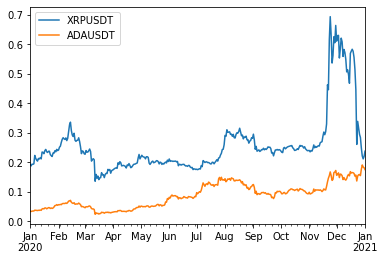

In [38]:
Combine.plot()

In [20]:
my_strategy = ep.create_strategy(Correlation_Pair_Trading, profit_take=50, stop_loss=-50, 
                                lag = 5, thed = 0.3, allow = 100)

In [21]:
my_strategy = ep.create_strategy(Cointegration_Pair_Trading, profit_take=50, stop_loss=-50, 
                                thed = 20, mu = mu, sd = sd, allow = 100)

In [34]:
interval = '1d'
startTime =  datetime.datetime(2020, 1, 1, 0, 0).timestamp()*1000
endTime = datetime.datetime(2021, 1, 1, 0, 0).timestamp()*1000
ticker = ['XRPUSDT','ADAUSDT']
universe = priceFrame(ticker,interval,startTime,endTime)

In [35]:
my_strategy.run(universe)

54 trades returned: trade(['XRPUSDT' 'ADAUSDT'], lot=[-224.00430088  639.1409945 ], entry=2020-12-22 00:00:00, take=50, stop=-50) ... Done. (Runtume: 0.1070 sec)
54 trades executed: trade(['XRPUSDT' 'ADAUSDT'], lot=[-224.00430088  639.1409945 ], entry=2020-12-22 00:00:00, take=50, stop=-50) ... Done. (Runtime: 0.2500 sec)
Done. Final wealth: 2996.46 (Runtime: 0.3590 sec)


strategy(Cointegration_Pair_Trading, profit_take=50, stop_loss=-50, thed=20, mu=1.042729958237425e-18, sd=0.010470009004027739, allow=100)

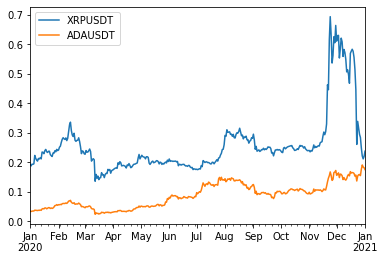

In [36]:
universe.plot()

In [25]:
df_history = my_strategy.history()
pd.set_option('display.max_rows', df_history.shape[0]+1)
df_history

,trade_id,asset,lot,entry,close,exit,take,stop,pnl
0,0,XRPUSDT,-374.013539,2020-02-04,2020-05-30,None,50,-50,22.575457
1,0,ADAUSDT,1785.395465,2020-02-04,2020-05-30,None,50,-50,37.314765
2,1,XRPUSDT,-360.048967,2020-02-05,2020-05-30,None,50,-50,25.466263
3,1,ADAUSDT,1685.487949,2020-02-05,2020-05-30,None,50,-50,29.630878
4,2,XRPUSDT,-353.045013,2020-02-06,2020-05-30,None,50,-50,26.916152
5,2,ADAUSDT,1664.447403,2020-02-06,2020-05-30,None,50,-50,28.012650
6,3,XRPUSDT,-357.743355,2020-02-07,2020-05-30,None,50,-50,25.943548
7,3,ADAUSDT,1670.285619,2020-02-07,2020-05-30,None,50,-50,28.461667
8,4,XRPUSDT,-360.555255,2020-02-08,2020-05-30,None,50,-50,25.361457
9,4,ADAUSDT,1666.111296,2020-02-08,2020-05-30,None,50,-50,28.140620


In [27]:
df_history.to_latex()

'\\begin{tabular}{lrlrlllrrr}\n\\toprule\n{} &  trade\\_id &    asset &          lot &      entry &      close &  exit &  take &  stop &        pnl \\\\\n\\midrule\n0   &         0 &  XRPUSDT &  -374.013539 & 2020-02-04 & 2020-05-30 &  None &    50 &   -50 &  22.575457 \\\\\n1   &         0 &  ADAUSDT &  1785.395465 & 2020-02-04 & 2020-05-30 &  None &    50 &   -50 &  37.314765 \\\\\n2   &         1 &  XRPUSDT &  -360.048967 & 2020-02-05 & 2020-05-30 &  None &    50 &   -50 &  25.466263 \\\\\n3   &         1 &  ADAUSDT &  1685.487949 & 2020-02-05 & 2020-05-30 &  None &    50 &   -50 &  29.630878 \\\\\n4   &         2 &  XRPUSDT &  -353.045013 & 2020-02-06 & 2020-05-30 &  None &    50 &   -50 &  26.916152 \\\\\n5   &         2 &  ADAUSDT &  1664.447403 & 2020-02-06 & 2020-05-30 &  None &    50 &   -50 &  28.012650 \\\\\n6   &         3 &  XRPUSDT &  -357.743355 & 2020-02-07 & 2020-05-30 &  None &    50 &   -50 &  25.943548 \\\\\n7   &         3 &  ADAUSDT &  1670.285619 & 2020-02-07 & 2

In [22]:
series_wealth = my_strategy.wealth()
series_wealth

2020-01-01       0.000000
2020-01-02       0.000000
2020-01-03       0.000000
2020-01-04       0.000000
2020-01-05       0.000000
                 ...     
2020-12-28    2996.460507
2020-12-29    2996.460507
2020-12-30    2996.460507
2020-12-31    2996.460507
2021-01-01    2996.460507
Length: 367, dtype: float64

In [23]:
my_strategy.score("max_drawdown")

-350.024207160254

In [24]:
my_strategy.score("final_wealth")

2996.460507291324

In [25]:
drawdown = my_strategy.drawdown()
exposure = my_strategy.net_exposure()

In [26]:
exposure.sum()/6200 - 1

0.6741443681141697

In [27]:
copula = copulae.GumbelCopula()
copula.fit(universe)
copula.params

          XRPUSDT     ADAUSDT
count  367.000000  367.000000
mean     0.500000    0.500000
std      0.288283    0.288283
min      0.002717    0.002717
25%      0.251359    0.251359
50%      0.500000    0.500000
75%      0.748641    0.748641
max      0.997283    0.997283


2.1195660860612437

In [28]:
1 - 1/copula.params

0.5282053215626392

In [29]:
universe.corr(method = 'kendall')

,XRPUSDT,ADAUSDT
XRPUSDT,1.000000,0.535934
ADAUSDT,0.535934,1.000000
